In [1]:
import seaborn
import pandas
import geopandas
import pysal
import numpy
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights


/opt/tljh/user/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/tljh/user/lib/python3.10/site-packages/quantecon/lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def simulate_linear_model(A, x0, v, ts_length):
/opt/tljh/user/lib/python3.10/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for 

In [2]:
pci_df = geopandas.read_file(
    "uscountypcincome.gpkg"
)
pci_df.columns


ERROR 1: PROJ: proj_create_from_database: Open of /opt/tljh/user/share/proj failed


Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [3]:
pci_df.shape

(3076, 77)

In [4]:
pci_df.query('NAME == "Jackson" & STATEFP == "28"').loc[
    :, "1969":"1979"
]


,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979
1417,2957,3121,3327,3939,4203,4547,5461,5927,6315,6619,6967


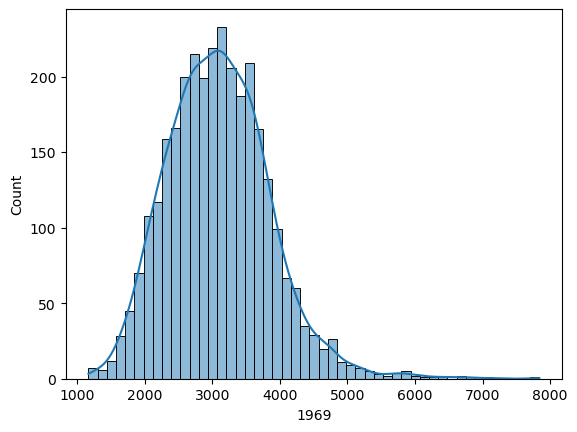

In [5]:
seaborn.histplot(x=pci_df["1969"], kde=True);

In [6]:
pci_df = pci_df.to_crs(
    # Albers Equal Area North America
    epsg=5070
)

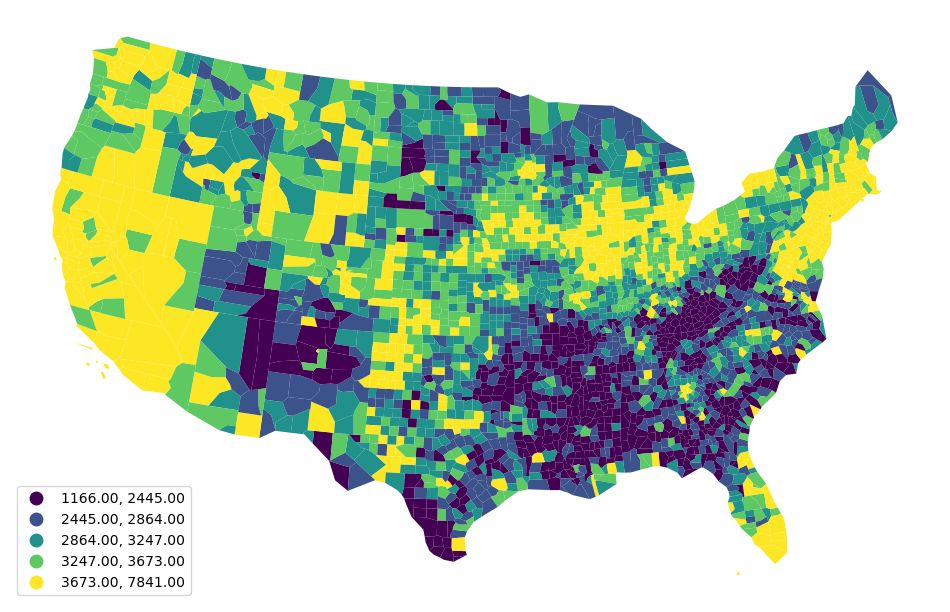

In [7]:
ax = pci_df.plot(
    column="1969",
    scheme="Quantiles",
    legend=True,
    edgecolor="none",
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.show()



In [8]:
top20, bottom20 = pci_df["1969"].quantile([0.8, 0.2])

In [9]:
top20/bottom20

1.5022494887525562

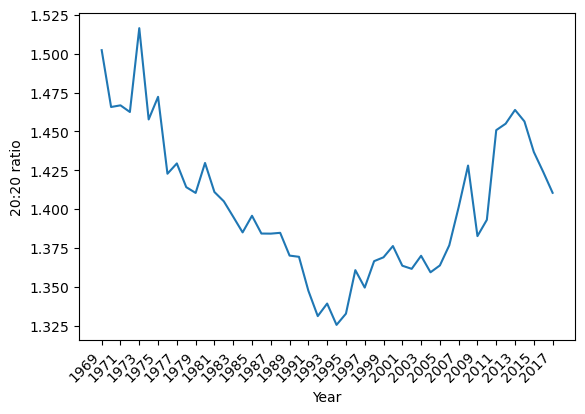

In [10]:
def ineq_20_20(values):
    top20, bottom20 = values.quantile([0.8, 0.2])
    return top20 / bottom20


# Generate range of strings from 1969 to 2018
years = numpy.arange(1969, 2018).astype(str)
# Compute 20:20 ratio for every year
ratio_2020 = pci_df[years].apply(ineq_20_20, axis=0)
# Plot evolution of 20:20 ratio
ax = plt.plot(years, ratio_2020)

# Grab figure generated in the plot
figure = plt.gcf()
# Replace tick labels with every other year
plt.xticks(years[::2])
# Set vertical label
plt.ylabel("20:20 ratio")
# Set horizontal label
plt.xlabel("Year")
# Rotate year labels
figure.autofmt_xdate(rotation=45)

plt.show()


In [11]:
from pysal.explore import inequality

In [12]:
n = len(pci_df)
share_of_population = numpy.arange(1, n + 1) / n

In [13]:
incomes = pci_df["1969"].sort_values()

In [14]:
shares = incomes / incomes.sum()


In [15]:
cumulative_share = shares.cumsum()

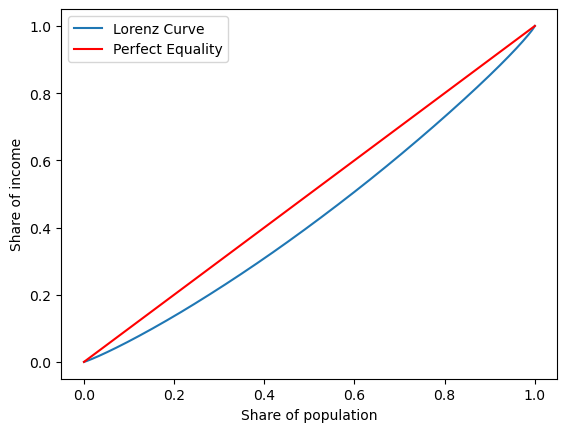

In [16]:
# Generate figure with one axis
f, ax = plt.subplots()
# Plot Lorenz Curve
ax.plot(share_of_population, cumulative_share, label="Lorenz Curve")
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="r", label="Perfect Equality")
# Label horizontal axis
ax.set_xlabel("Share of population")
# Label vertical axis
ax.set_ylabel("Share of income")
# Add legend
ax.legend()

plt.show()



In [17]:
def lorenz(y):
    y = numpy.asarray(y)
    incomes = numpy.sort(y)
    income_shares = (incomes / incomes.sum()).cumsum()
    N = y.shape[0]
    pop_shares = numpy.arange(1, N + 1) / N
    return pop_shares, income_shares

In [18]:
lorenz(pci_df["1969"])

(array([3.25097529e-04, 6.50195059e-04, 9.75292588e-04, ...,
        9.99349805e-01, 9.99674902e-01, 1.00000000e+00]),
 array([1.22486441e-04, 2.52956561e-04, 3.83636778e-04, ...,
        9.98429316e-01, 9.99176315e-01, 1.00000000e+00]))

In [19]:
lorenz_curves = pci_df[years].apply(lorenz, axis=0)

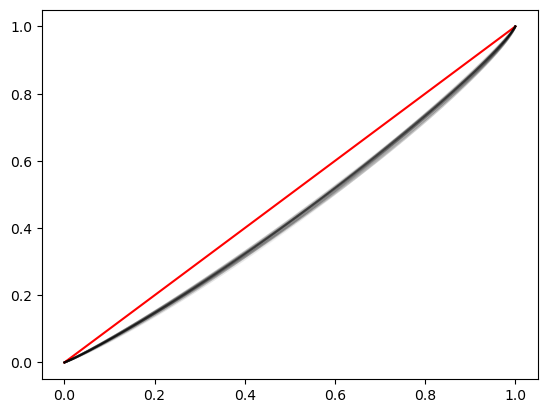

In [23]:
# Set up figure with one axis
f, ax = plt.subplots()
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="r")
# Loop over every year in the series
for year in lorenz_curves.columns:
    # Extract the two arrays or each dimension
    year_pop_shares, year_inc_shares = lorenz_curves[year].values
    # Plot Lorenz curve for a given year
    ax.plot(year_pop_shares, year_inc_shares, color="k", alpha=0.05)

In [24]:
g69 = inequality.gini.Gini(pci_df["1969"].values)

In [25]:
g69.g

0.13556175504269904

In [26]:
def gini_by_col(column):
    return inequality.gini.Gini(column.values).g

In [27]:
inequalities = (
    pci_df[years].apply(gini_by_col, axis=0).to_frame("gini")
)

In [28]:
inequalities.head()

,gini
1969,0.135562
1970,0.130076
1971,0.128540
1972,0.129126
1973,0.142166


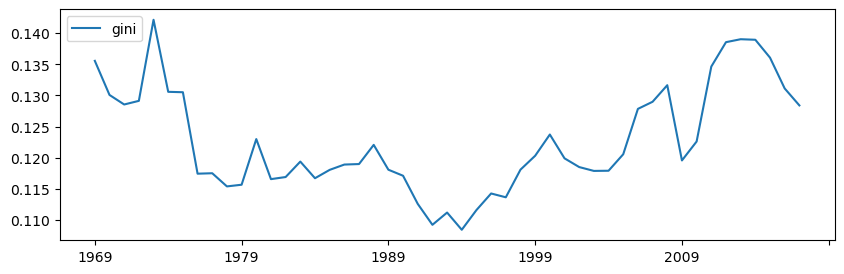

In [30]:
inequalities.plot(figsize=(10, 3));

In [33]:
def theil(column):
    return inequality.theil.Theil(column.values).T


inequalities["theil"] = pci_df[years].apply(theil, axis=0)


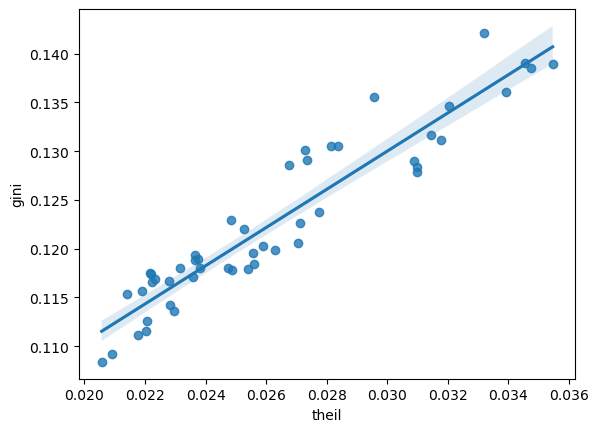

In [34]:
_ = seaborn.regplot(x="theil", y="gini", data=inequalities)

In [41]:
wq = weights.Queen.from_dataframe(pci_df)

/tmp/ipykernel_268899/2833574135.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.Queen.from_dataframe(pci_df)


In [42]:
def moran_by_col(y, w=wq):
    mo = esda.Moran(y, w=w)
    mo_s = pandas.Series(
        {"I": mo.I, "I-P value": mo.p_sim},
    )
    return mo_s


In [43]:
moran_stats = pci_df[years].apply(moran_by_col, axis=0).T

moran_stats.head()


,I,I-P value
1969,0.649090,0.001
1970,0.647438,0.001
1971,0.626546,0.001
1972,0.606760,0.001
1973,0.640226,0.001


In [38]:
inequalities = inequalities.join(moran_stats)

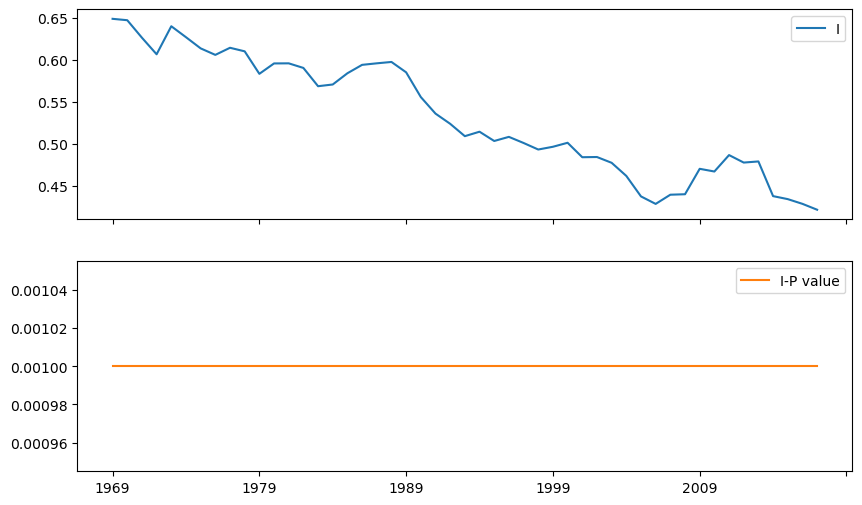

In [39]:
inequalities[["I", "I-P value"]].plot(subplots=True, figsize=(10, 6))
plt.show()


In [44]:
region_names = {
    1: "New England",
    2: "Mideast",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountain",
    8: "Far West",
}

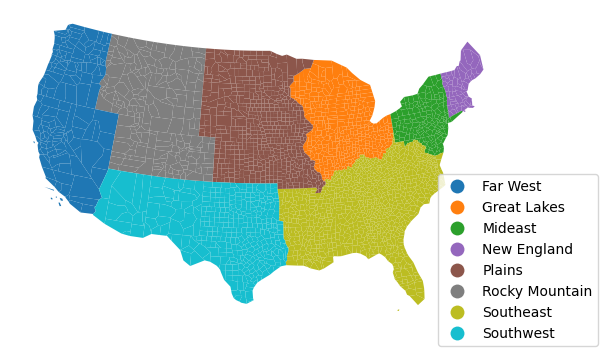

In [46]:
ax = pci_df.assign(Region_Name=pci_df.Region.map(region_names)).plot(
    "Region_Name",
    linewidth=0,
    legend=True,
    categorical=True,
    legend_kwds=dict(bbox_to_anchor=(1.2, 0.5)),
)
ax.set_axis_off();


In [54]:
theil_dr = inequality.theil.TheilD(
    pci_df[years].values, pci_df.Region
)


In [55]:
theil_dr.bg

array([0.00914353, 0.00822696, 0.00782675, 0.00768201, 0.01022634,
       0.0081274 , 0.00783943, 0.00572543, 0.00560271, 0.0054971 ,
       0.00511791, 0.00566001, 0.00486877, 0.00466134, 0.00474425,
       0.00424528, 0.00428434, 0.00453503, 0.00465829, 0.00456699,
       0.00467363, 0.00412391, 0.00366334, 0.00342112, 0.00327131,
       0.00312475, 0.00326071, 0.00359733, 0.00327591, 0.00363014,
       0.00382409, 0.00436261, 0.00399156, 0.00402506, 0.00397   ,
       0.00394649, 0.00353368, 0.00362698, 0.00400508, 0.00449814,
       0.0043533 , 0.00470988, 0.0063954 , 0.00642426, 0.00694236,
       0.00644971, 0.00591871, 0.00554072, 0.00528702])

In [56]:
inequalities["theil_between"] = theil_dr.bg
inequalities["theil_within"] = theil_dr.wg


In [57]:
inequalities["theil_between_share"] = (
    inequalities["theil_between"] / inequalities["theil"]
)


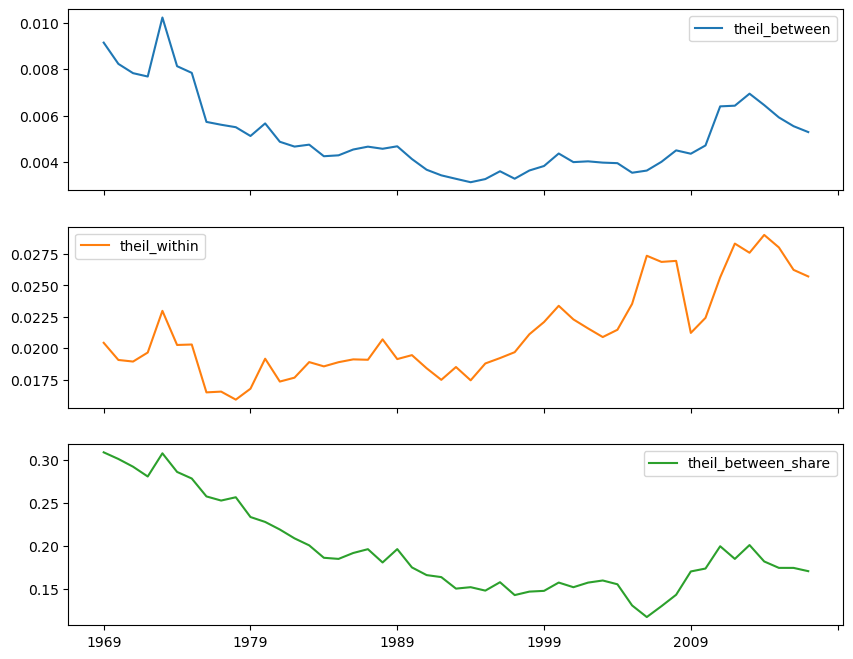

In [58]:
inequalities[
    ["theil_between", "theil_within", "theil_between_share"]
].plot(subplots=True, figsize=(10, 8));

In [59]:
theil_drs = inequality.theil.TheilDSim(
    pci_df[years].values, pci_df.Region
)


In [45]:
theil_drs.bg_pvalue

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01])

In [60]:
sim = theil_drs.bg[1:,:]

In [61]:
sim.shape

(99, 49)

In [62]:
import pandas as pd
df = pd.DataFrame(index=years, data={'mean':sim.mean(axis=0), 'std': sim.std(axis=0)})

<Axes: >

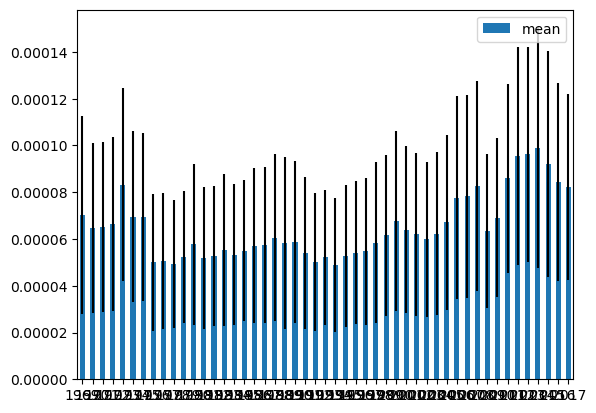

In [63]:
df.plot(kind='bar', y='mean', yerr='std', rot=0)

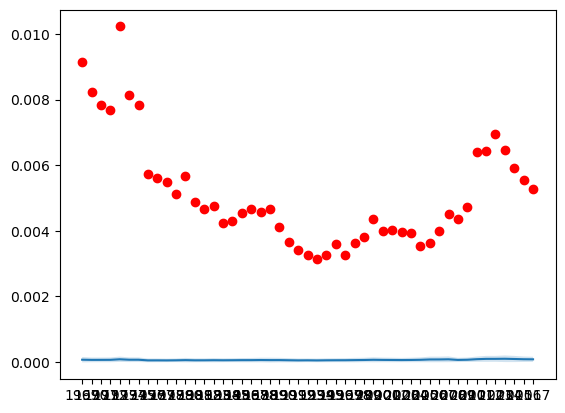

In [64]:
fig, ax = plt.subplots()
ax.plot(years, theil_drs.bg[0], 'o', color='r')
ax.fill_between(years, df['mean']- 1.96*df['std'], df['mean']+ 1.96*df['std'], alpha=0.2)
ax.plot(years, df['mean']);

In [65]:
import matplotlib.ticker as mticker

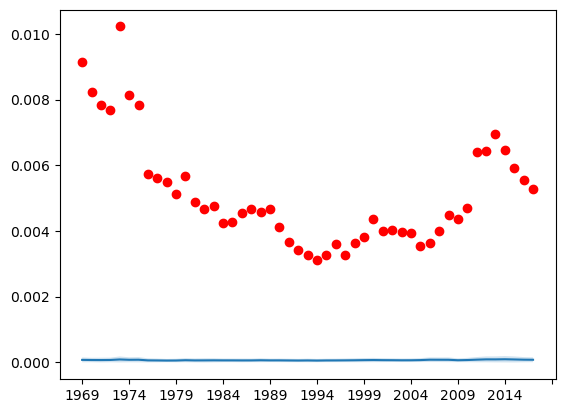

In [57]:
myLocator = mticker.MultipleLocator(5)
ax.xaxis.set_major_locator(myLocator)
fig, ax = plt.subplots()
ax.plot(years, theil_drs.bg[0], 'o', color='r')
ax.fill_between(years, df['mean']- 1.96*df['std'], df['mean']+ 1.96*df['std'], alpha=0.2)
ax.plot(years, df['mean'])
myLocator = mticker.MultipleLocator(5)
ax.xaxis.set_major_locator(myLocator);

In [60]:
df.columns

Index(['mean', 'std'], dtype='object')

In [61]:
df.head()

,mean,std
1969,0.000071,0.000037
1970,0.000067,0.000034
1971,0.000065,0.000036
1972,0.000068,0.000036
1973,0.000084,0.000046
